## Analyzing NYC High School Data
### Introduction
The aim of this project is to explore relashionships between SAT scores and demographic factors in New York City public schools.
The Scholarship Aptitude Test [SAT](https://en.wikipedia.org/wiki/SAT) is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on [students SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) by high school, along with additional demographic data sets.

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test.

### Read Data

In [1]:
import pandas as pd
import numpy
import re

# read data
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [2]:
# read surveys
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  after removing the cwd from sys.path.


### Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

### Plot survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
%matplotlib inline

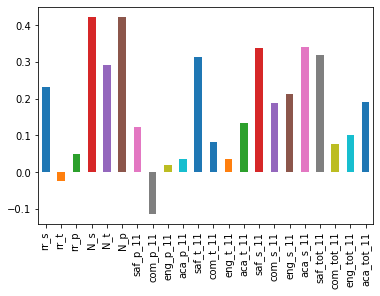

In [12]:
combined.corr()["sat_score"][survey_fields].plot.bar()

There are high correlations between `N_s`, `N_t`, `N_p` and `sat_score`. Since these columns are correlated with `total_enrollment`, it makes sense that they would be high.

It is more interesting that `rr_s`, the student response rate, or the percentage of students that completed the survey, correlates with `sat_score`. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (`saf_t_11` and `saf_s_11`) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the `aca_s_11`, which indicates how the student perceives academic standards, correlates with `sat_score`, but this is not true for `aca_t_11`, how teachers perceive academic standards, or `aca_p_11`, how parents perceive academic standards.

### Exploring Safety and SAT Scores
As we noticed, `saf_t_11` and `saf_s_11` (how teachers and students perceive safety at school) correlated highly with `sat_score`. Let's dig into this relationship and try to figure out which schools have low safety scores.

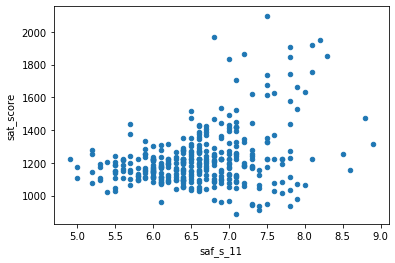

In [13]:
combined.plot.scatter("saf_s_11", "sat_score")

There is a correlation between SAT scores and safety in schools, although it is not that strong. The highest SAT scores are registered in schools with a safety score of 6.8 or higher, but there are some very safe schools with low sat scores. The maximum safety score, between 8.5 and 9, have schools with low sat score, between 1200 and 1500.

Let's map out safety scores by district.

C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


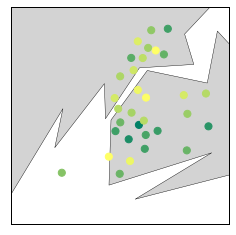

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='l'
)

m.drawmapboundary()
m.drawcoastlines(color='black', linewidth=.4)
m.drawrivers(color='blue')
m.fillcontinents(color='lightgrey')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.

### Exploring Race and SAT Scores
Let's plot out the correlation between race columns and SAT scores.

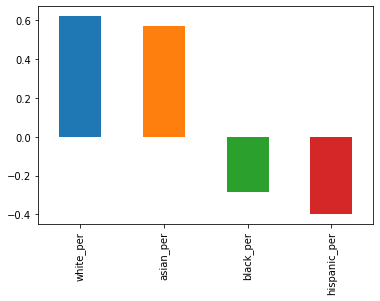

In [15]:
races = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][races].plot.bar()

The white and asian students correlate positively with SAT scores, while the black and hispanic students correlate negatively. We tend to presume that areas, where are predominantly black or hispanic, have lack of fundings.
Let's keep exploring.

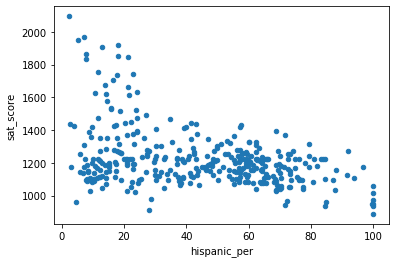

In [16]:
combined.plot.scatter("hispanic_per","sat_score" )

The scatter plot above shows that schools with predominantly hispanic students have low SAT scores. Let's find the schools with a percentage of greater than 95 of hispanic students.

In [17]:
print(combined[combined["hispanic_per"]>95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


After a short online research we find the schools listed above appear to primarily be enrolled recent U.S. immigrants or represent a high percentage of minority enrolment or students with economical disadvantaged, as an example [Manhattan Bridges High School](https://www.usnews.com/education/best-high-schools/new-york/districts/new-york-city-public-schools/manhattan-bridges-high-school-13105). These schools have a lot of students who are learning English, which would explain the lower SAT scores.

Let's find the schools with less than 10% hispanic students and the average SAT score greater than 1800.

In [18]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


As [Stuyvesant High School](https://en.wikipedia.org/wiki/Stuyvesant_High_School) is, many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic enrollment, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

### Exploring Gender and SAT Scores
Let's continue by exploring the correlation between SAT score and gender.

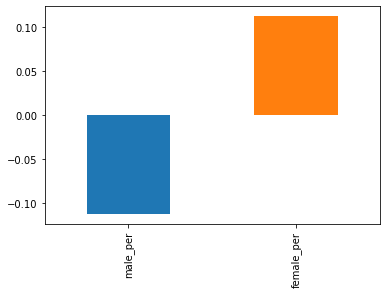

In [19]:
cols = ["male_per", "female_per"]
combined.corr()["sat_score"][cols].plot.bar()

In the plot above we can see that female students positively correlate with SAT score and males correlate negatively. Neither of the correlation is very strong.
Let's explore the female representation of our data.

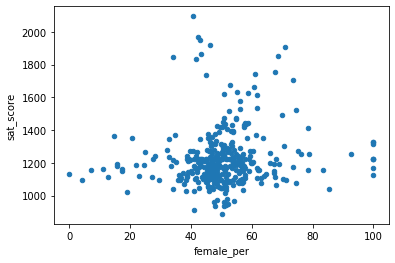

In [20]:
combined.plot.scatter("female_per", "sat_score")

Based on the plot above, there doesn't seem to be any real correlation between `sat_score` and `female_per`. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [21]:
print(combined[(combined["female_per"]>60)&(combined["sat_score"]>1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


[Bard High School Early College](https://bhsec.bard.edu/) and other from the list appear to be very selective liberal arts schools that have high academic standards.

### Exploring AP Scores vs. SAT Scores
In the U.S., high school students take [Advanced Placement](https://en.wikipedia.org/wiki/Advanced_Placement_exams) exams for many different subjects to earn college credit.
Let's look at the percentage of students in each school who took at least one AP exam.

In [22]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]

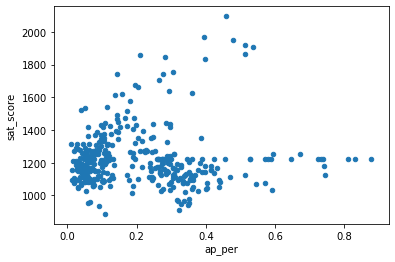

In [23]:
combined.plot.scatter("ap_per", "sat_score")

The plot above doesn't show a strong correlation between students who took AP exams and the SAT score.

Let's determine now whether there is a correlation between class size and SAT score.
### Exploring Class Size and SAT Scores Correlation

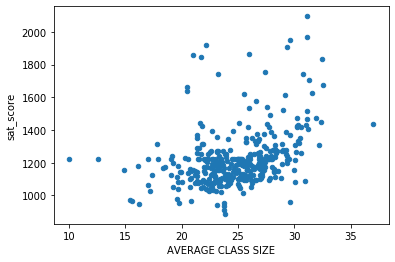

In [24]:
combined.plot.scatter("AVERAGE CLASS SIZE", "sat_score")

It doesn't seem to be a strong correlation between the class size and SAT scores.